In [16]:
import matplotlib.pyplot as plt
from notebook_env import *
import pandas as pd
import numpy as np
import json

In [4]:
f_path = f'{datasets_directory}/heval_and_mbpp.json'

In [5]:
binary_contract = statcontracts.HumanEvalContractWrapper(f_path)

In [6]:
#binary_contract.get_possible_models()
df = binary_contract.get_distributions(binary_contract.get_possible_models(), ['heval','mbpp'])
df.sort_index(key = lambda s: df.loc[s]['heval'])

,heval,mbpp
model,,
zyte-1B,2.4,9.8
StableLM-7B,2.4,NaN
PolyCoder-2.7B,6.1,NaN
GPT-Neo-2.7B,7.9,NaN
CodeGen2-1B,11.0,NaN
...,...,...
claude-3-opus (Mar 2024),82.9,89.4
CodeQwen1.5-7B-Chat,83.5,79.4
GPT-4-Turbo (Nov 2023),85.4,85.7


### Define the models of relevance and cost structure

In [7]:
rlvnt_models = [f'CodeLlama-{i}B' for i in ['7','13','70']]
#energy costs from huggingface llm-perf leaderboard
doll_per_token = 0.105
costs=np.array([1.73,2.3,6.1])*doll_per_token
pass_rates = {'heval': [33.5,36.0,53.0], 'mbpp': [41.4,47.0, 62.4]}
rlvnt_bnmks = ['heval', 'mbpp']
#print(opens_big_models)
list(zip(rlvnt_models,costs))

[('CodeLlama-7B', 0.18164999999999998),
 ('CodeLlama-13B', 0.24149999999999996),
 ('CodeLlama-70B', 0.6405)]

In [8]:
contract_df = pd.DataFrame(pass_rates, index = rlvnt_models)
contract_df

,heval,mbpp
CodeLlama-7B,33.5,41.4
CodeLlama-13B,36.0,47.0
CodeLlama-70B,53.0,62.4


In [11]:
t_opt_dct = {}
c = np.array(costs)
c_rob = np.array([0,0,costs[-1]-costs[0]])
for bnmk in rlvnt_bnmks:
    F = contract_df[bnmk].to_numpy()
    f_fail  = 100-F
    F = np.concatenate([f_fail.reshape(-1,1), F.reshape(-1,1)], axis = 1)
    F = F / F.sum(axis=1,keepdims=True)
    #print(f'{bnmk} \n F: {F}')
    for cost_type, cost in zip(['aware', 'rob'], [c,c_rob]):
        t_opt_dct[f'{bnmk}_{cost_type}'] = statcontracts.MinPayOptimizer.solve(F,cost)  # only need this because all objectives are the same in binary outcome

In [12]:
t_opt_dct

{'heval_aware': array([0.        , 2.35307692]),
 'heval_rob': array([0.        , 2.69911765]),
 'mbpp_aware': array([0.        , 2.59090909]),
 'mbpp_rob': array([0.        , 2.97954545])}

## Plot contracts and analysis

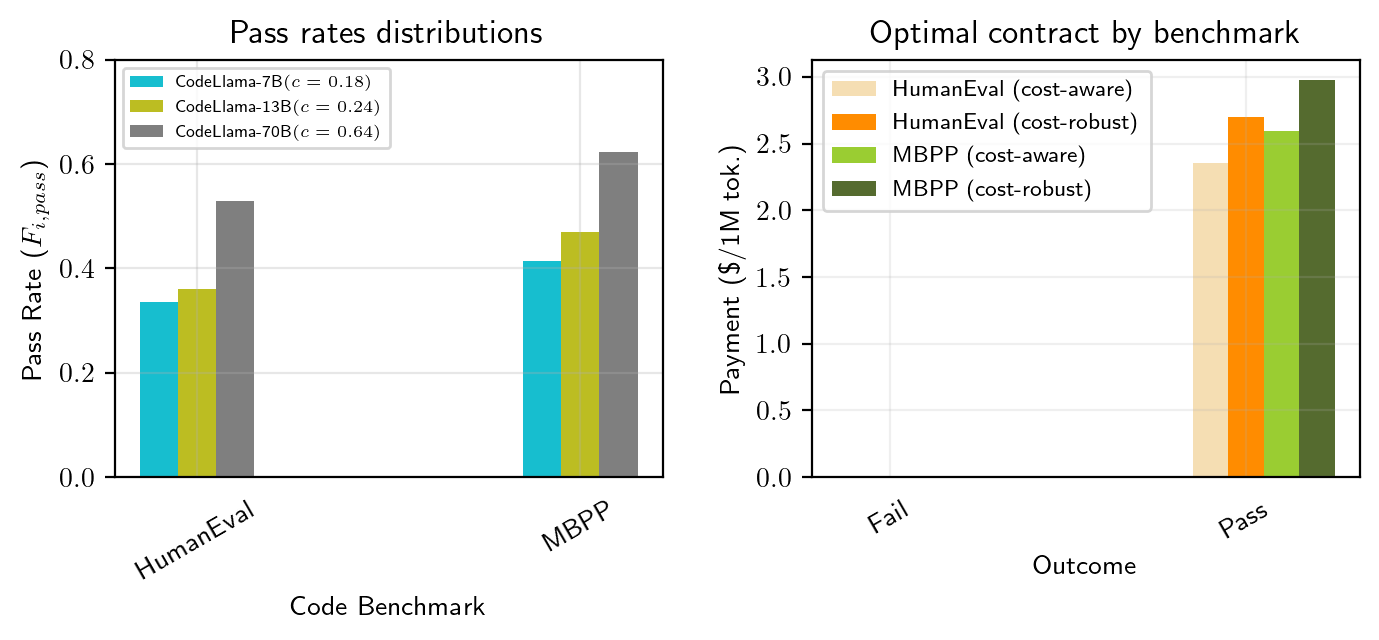

In [14]:
fig = plt.figure(figsize=(7,3.3),tight_layout={'w_pad':2})
#outcome distribution/pass rates
ax = fig.add_subplot(1,2,1)
width  = 0.1
offsets = [-1*width,0,1*width,2*width]
mdl_colors = {mdl: color for mdl, color in zip(rlvnt_models,list(matplotlib.colors.TABLEAU_COLORS)[::-1])}
cost_dct = {mdl: cost for mdl, cost in zip(rlvnt_models, costs)}
bnmk_dct = {'heval': 'HumanEval', 'mbpp': 'MBPP', 'heval_aware': 'HumanEval (cost-aware)', 'heval_rob': 'HumanEval (cost-robust)', 'mbpp_aware': 'MBPP (cost-aware)', 'mbpp_rob': 'MBPP (cost-robust)'}

for i,bnmk in enumerate(rlvnt_bnmks):
    for j, mdl in enumerate(rlvnt_models):
        pass_rate = contract_df.query('index == @mdl')[bnmk].item()/100
        # print(f'{mdl} {bnmk} {pass_rate}')
        # print(f'{i} {j} {offsets[j]}')
        ax.bar(i+offsets[j], pass_rate, width=width, color = mdl_colors[mdl], label=mdl + f'$(c={cost_dct[mdl]:.2f})$')

ax.set_xticks(range(len(rlvnt_bnmks)), [bnmk_dct[bmk] for bmk in rlvnt_bnmks], rotation=30)
ax.set(
    title='Pass rates distributions',
    xlabel='Code Benchmark',
    ylabel='Pass Rate ($F_{i,pass}$)',
    ylim = (0,0.8)
    )
ax.xaxis.set_ticks_position('none')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.grid(alpha= 0.3)
ax.legend(by_label.values(), by_label.keys(), fontsize=6, loc='upper left')

ax = fig.add_subplot(1,2,2)
x = np.arange(2)
bnmk_colors = {bnmk: color for bnmk, color in zip(rlvnt_bnmks, [f'C{i}' for i in range(1,5)])}
colors = ['wheat','darkorange','yellowgreen','darkolivegreen']
for i, (bnmk, t) in enumerate(t_opt_dct.items()):
    ax.bar(x+offsets[i], t, width=width, label=bnmk_dct[bnmk],color = colors[i])
ax.set_xticks(x, ['Fail', 'Pass'], rotation=30)
ax.set(
    title='Optimal contract by benchmark',
    ylabel='Payment (\$/1M tok.)',
    xlabel='Outcome'
    )
ax.grid(alpha= 0.2)
ax.xaxis.set_ticks_position('none')
ax.legend(fontsize=8)

### Save the contracts to a json file

In [17]:
results_directory = './results'
contract_df.to_csv(f'{results_directory}/binary_F.csv',index=False)

In [20]:
with open(f'{results_directory}/binary_contracts.json', 'w') as f:
    json.dump({k:list(v) for k,v in t_opt_dct.items()}, f)